### Goal

We have collected a number of tweets and dumped them in a database. If not, check out the "gather-twitter-info-example" notebook. We want to get an idea what people in the network are talking about, but we don't want to go through the tweets manually. Let's use the magic of machine learning instead: We learn a very simple text classifier on example texts and classify the tweets into these categories. 

### Train and profile classifier

Let's train the text classifier on ~18000 newsgroup posts on 20 different topics (http://scikit-learn.org/stable/datasets/twenty_newsgroups.html). This data can be easily loaded from the scikit-learn library.  

#### Load data

In [12]:
%load_ext autoreload
%autoreload 2
from sklearn.datasets import fetch_20newsgroups
 
twenty_train = fetch_20newsgroups(subset='train', shuffle=True, random_state=32)
twenty_test = fetch_20newsgroups(subset='test', shuffle=True, random_state=32)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Train classifier

In the best case scenario this text classifier should be able to classify tweets from the pre-filtered twitter stream directly. So speed does matter. Therefore let's use a simple linear classifier: A multinomial naive bayesian classifier (http://scikit-learn.org/stable/modules/naive_bayes.html). To be able to classify text we first want to create a sparse vector representation of the documents (http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) and tf-idf transform (https://en.wikipedia.org/wiki/Tf%E2%80%93idf) to take relative term frequency (tf) and inverse document frequency (idf) into account (http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html). 

We combine the CountVectorizer, TfidfTransformer and Classifier into a scikit-learn pipeline and identify the optimal set of meta parameters using 5-fold cross validation combined with a grid search. The parameters we are optimizing for are i) n-gram length for feature extraction (1 word or 1 and 2 words) and ii) the additive smoothing term for the naive bayes classifier. 

Let's train the classifier and save it for further use. 

In [20]:
from src.message_classifier import MessageClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

tc = MessageClassifier()

# Define the pipeline and meta-parameters to optimize the model via Cross-validiation 
pipeline=Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('nb', MultinomialNB())])
param_grid={'vect__ngram_range': [(1, 1),(1, 2)], 'nb__alpha': [10**-5,10**-4,10**-3,10**-2,10**-1]}

# Perform the parameter sweep, retain the optimal model and save it 
tc.train(train_X=twenty_train.data, train_y=twenty_train.target, labels=twenty_train.target_names, pipeline=pipeline, param_grid=param_grid)
tc.dump('data/tweet_clf_nb')

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  5.6min finished


Best score 0.917093866007 of estimator Pipeline(steps=[('vect', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
        st...alse,
         use_idf=True)), ('nb', MultinomialNB(alpha=0.001, class_prior=None, fit_prior=True))])


#### Profile classifier. 

The cross validation reports an f1-score (weighted average of precision and recall) averaged over all classes of 0.92 for the optimal parameters (1 and 2 grams / alpha = 10^-3). Let us see how the classifier performs on the hold-out data set. 

In [21]:
tc.test(valid_X=twenty_test.data, valid_y=twenty_test.target) # Test performace on hold-out set

                          precision    recall  f1-score   support

             alt.atheism       0.82      0.82      0.82       319
           comp.graphics       0.69      0.74      0.71       389
 comp.os.ms-windows.misc       0.73      0.62      0.67       394
comp.sys.ibm.pc.hardware       0.64      0.76      0.69       392
   comp.sys.mac.hardware       0.82      0.82      0.82       385
          comp.windows.x       0.83      0.79      0.81       395
            misc.forsale       0.86      0.83      0.84       390
               rec.autos       0.88      0.89      0.89       396
         rec.motorcycles       0.95      0.94      0.95       398
      rec.sport.baseball       0.96      0.92      0.94       397
        rec.sport.hockey       0.95      0.97      0.96       399
               sci.crypt       0.86      0.92      0.89       396
         sci.electronics       0.79      0.74      0.77       393
                 sci.med       0.88      0.83      0.85       396
         

#### Profiling summary 
We trained a multinomial naive bayes classifier, which gives us reasonable classification performance (average f1 = 0.84). Importantly, we expect this classifier to be fast and will hopefully allow us to classify tweets on the fly. 

### Classify tweets
Now that we trained a classifier, we can classify the tweets we collected and stored in our database. First let us connect to the database (if you do not set up a database, please follow the notebook: 'gather-twitter-info-example') and retrieve all the messages. If you have a lot, you may want to classify in batches.  

In [25]:
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
from sqlalchemy.sql import exists
from src.db_tables import Base, Message, create_sqlite_db

# Connect to database 
engine = create_engine('sqlite:///data/testuser.db')
Base.metadata.bind = engine 
DBSession = sessionmaker(bind=engine)
session = DBSession()

# Retrieve all messages
messages = [getattr(x, "text").encode('utf-8') for x in session.query(Message).all()]

Now can simply classify and get the class probability for each message. 

In [26]:
probabilities = tc.predict_proba(messages)

#### Interpretation of the predictions. 

Let us look at the prediction. For starters let us see how often each class was assigned and how confident the classifier was in the prediction. 

class                                              sci.crypt
message    Statistics for Hackers by @jakevdp. Nico intro...
prob                                               0.5049103
Name: 3, dtype: object


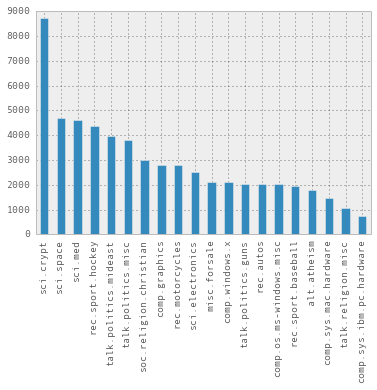

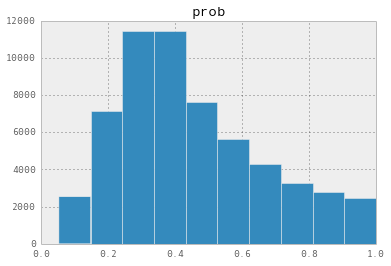

In [59]:
import scipy as sp 
import pandas as pd
pd.set_option('display.mpl_style', 'default') # Make the graphs a bit prettier
from matplotlib import pyplot as plt
%matplotlib inline

# Summary statistics of tweet classification 
row_list = [] 
for message, probs in zip(messages, probabilities): 
    row_list.append({'class':tc.labels[np.argmax(probs)], 'prob':np.max(probs), 'message':message})
df = pd.DataFrame(row_list)

# Let's check out one example. 
print(df.iloc[3])

# Plot frequency of class
df['class'].value_counts().plot(kind='bar');

# Plot how probabilities are distributed 
df.hist(); 

The example shows a reasonable classification. Some tweets containing statistics and hacker would fit into a crypto newsgroup. The classifier assigns this class a probability of 0.5 for this tweet. 

The three most assigned classes were all from science newsgroups (sci.). This makes sense, knowing that the twitter user we used as the root node of the network analysis mainly tweets about scientific topics. The average prediction probability was 0.45. This is actually quite high considering that the probabilities are distributed over 20 classes for each fit.  

### Summary 

Having collected a number of tweets and stored it in the database, allows easy access to analysis tools. Here we train a tweet classifier, allowing us to go through a large number of tweets and filter out tweets on topics of interest. 